In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.optim as optim

/kaggle/input/e-commerce-synthetic-dataset/ecommerce_synthetic_data.csv


In [2]:
training_data = pd.read_csv("/kaggle/input/e-commerce-synthetic-dataset/ecommerce_synthetic_data.csv")
training_data.head()

,ordered,past_spending,price,quantity,membership_flag,goods_type_clothing,goods_type_eletronics,goods_type_food,goods_type_furniture,goods_type_kichenware,goods_type_medicine,brand_tier_cheap,brand_tier_highend,brand_tier_popular
0,0,1023.73,75.934756,1,0,1,0,0,0,0,0,1,0,0
1,0,0.00,278.957661,2,0,0,1,0,0,0,0,0,1,0
2,0,1873.31,7.383762,5,0,1,0,0,0,0,0,0,1,0
3,0,592.82,72.419637,1,0,0,1,0,0,0,0,0,0,1
4,0,796.50,350.501563,1,1,0,0,0,1,0,0,0,0,1


In [3]:
# Good's type column from one-hot encoded columns for stratification
goods_type = pd.from_dummies(
    training_data[[x for x in training_data.columns if "goods_type" in x]], 
    sep="_",
)

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    training_data[[x for x in training_data.columns if x != "ordered"]], 
    training_data["ordered"], 
    test_size=0.5, 
    random_state=2024, 
    stratify=goods_type,
)

# Features in training set
features_train = X_train[[x for x in X_train.columns if x != "price"]]
features_scaler = StandardScaler().fit(features_train[["past_spending", "quantity"]])
features_train[["past_spending", "quantity"]] = features_scaler.transform(
    features_train[["past_spending", "quantity"]]
)

# Features in testing set
features_test = X_test[[x for x in X_test.columns if x != "price"]]
features_test[["past_spending", "quantity"]] = features_scaler.transform(
    features_test[["past_spending", "quantity"]]
)

In [4]:
price_with_goods_type = pd.concat([training_data["price"], goods_type], axis=1)
price_train = price_with_goods_type[price_with_goods_type.index.isin(X_train.index)]
price_test = price_with_goods_type[price_with_goods_type.index.isin(X_test.index)]

for x in price_with_goods_type["goods"].unique():
    price_train_scale = price_train.loc[price_train["goods"] == x, "price"].values.reshape(-1,1)
    price_test_scale = price_test.loc[price_test["goods"] == x, "price"].values.reshape(-1,1)
    # Scale with training prices
    price_scaler = StandardScaler().fit(price_train_scale)
    price_train.loc[price_train["goods"] == x, "price"] = price_scaler.transform(price_train_scale)
    price_test.loc[price_test["goods"] == x, "price"] = price_scaler.transform(price_test_scale)

print("Scaled prices evenly distributed across good's type")
price_test.groupby("goods")["price"].describe().round(3)

Scaled prices evenly distributed across good's type


,count,mean,std,min,25%,50%,75%,max
goods,,,,,,,,
type_clothing,1675.0,0.014,0.996,-1.238,-0.745,-0.264,0.544,3.478
type_eletronics,1652.0,-0.029,1.024,-1.301,-0.826,-0.324,0.570,3.499
type_food,1628.0,0.032,1.028,-1.252,-0.756,-0.273,0.606,3.339
type_furniture,1660.0,0.021,1.072,-1.283,-0.773,-0.286,0.543,3.513
type_kichenware,1732.0,-0.005,0.985,-1.248,-0.767,-0.279,0.550,3.297
type_medicine,1653.0,-0.050,0.981,-1.243,-0.799,-0.347,0.489,3.472


In [5]:
# # Features for model training except for price feature
# features = training_data[[x for x in training_data.columns if x not in ["ordered", "price"]]]
# features[["past_spending", "quantity"]] = StandardScaler().fit_transform(
#     features[["past_spending", "quantity"]]
# ) # Continuous features

# # Scale prices by good's type
# price_with_goods_type = pd.concat(
#     [
#         training_data["price"],
#         pd.from_dummies(training_data[[x for x in training_data.columns if "goods_type" in x]], sep="_"),
#     ], 
#     axis=1,
# )
# prices = price_with_goods_type.groupby("goods")["price"].transform(
#     lambda x: StandardScaler().fit_transform(x.values[:,np.newaxis]).ravel()
# ).values.reshape(-1,1)

# # Averge price by good's type
# price_with_goods_type.groupby("goods").mean().reset_index().round(2)

In [6]:
# Convert dataframe and numpy array into tensors
features_train_tensor = torch.tensor(features_train.values, dtype=torch.float32)
price_train_tensor = torch.tensor(price_train["price"].values.reshape(-1,1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1,1), dtype=torch.float32)

features_test_tensor = torch.tensor(features_test.values, dtype=torch.float32)
price_test_tensor = torch.tensor(price_test["price"].values.reshape(-1,1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1,1), dtype=torch.float32)

In [7]:
class MaxWinRateParam(nn.Module):
    def __init__(self):
        super(MaxWinRateParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.output_layer = nn.Linear(5, 1)
        self.sigmoid_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        x = self.sigmoid_activation(x)
        return x


class BiasParam(nn.Module):
    def __init__(self):
        super(BiasParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.relu_activation = nn.ReLU()
        self.output_layer = nn.Linear(5, 1)
        self.elu_activation = nn.ELU()

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.relu_activation(x)
        x = self.output_layer(x)
        x = self.elu_activation(x)
        return x


class SensitivityParam(nn.Module):
    def __init__(self):
        super(SensitivityParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.relu_activation = nn.ReLU()
        self.output_layer = nn.Linear(5, 1)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.relu_activation(x)
        x = self.output_layer(x)
        x = self.relu_activation(x)
        return x


class WinRateNetwork(nn.Module):
    def __init__(self):
        super(WinRateNetwork, self).__init__()
        self.max_win_rate = MaxWinRateParam()
        self.bias = BiasParam()
        self.sensitivity = SensitivityParam()

    def forward(self, features, price, train=False):
        mul_term = torch.mul(self.sensitivity(features), price)
        add_term = torch.add(self.bias(features), mul_term)
        win_rate = self.max_win_rate(features) / (1 + torch.exp(add_term))
        if train:
            return win_rate
        return (
            win_rate,
            self.max_win_rate(features),
            self.bias(features),
            self.sensitivity(features),
        )

In [8]:
# Training parameters
n_epochs = 500
batch_size = 256
batches_per_epoch = len(features_train_tensor) // batch_size

# Model settings
model = WinRateNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(n_epochs):
    if epoch % 100 == 0:
        print(f"Epoch: {epoch + 1}")
    for i in range(batches_per_epoch):
        start = i * batch_size
        X_batch = features_train_tensor[start:(start + batch_size)]
        price_batch = price_train_tensor[start:(start + batch_size)]
        y_batch = y_train_tensor[start:(start + batch_size)]
        # Forward pass
        y_pred = model(X_batch, price_batch, train=True)
        loss = criterion(y_pred, y_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # Update weights

Epoch: 1
Epoch: 101
Epoch: 201
Epoch: 301
Epoch: 401


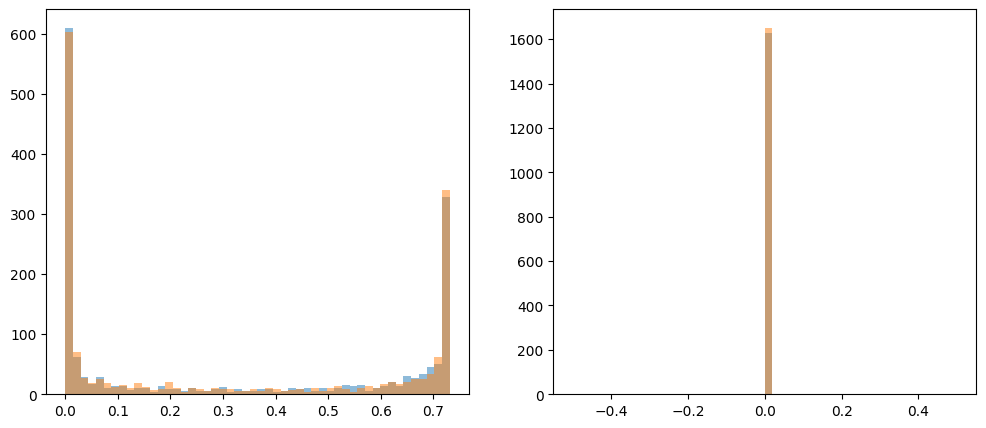

In [9]:
win_rate_test, max_win_rate_test, bias_test, sensitivity_test = model(features_test_tensor, price_test_tensor)

pred_win_rate_test = win_rate_test.detach().numpy()
pred_max_win_rate_test = max_win_rate_test.detach().numpy()
pred_bias_test = bias_test.detach().numpy()
pred_sensitivity_test = sensitivity_test.detach().numpy()

pred_goods_test = pd.concat(
    [
        goods_type[goods_type.index.isin(X_test.index)].reset_index(), 
        pd.Series(pred_win_rate_test.ravel(), name="predicted_win_rate"),
        pd.Series(pred_sensitivity_test.ravel(), name="predicted_sensitivity"),
    ], 
    axis=1,
)

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].hist(
    pred_goods_test.loc[pred_goods_test["goods"] == "type_food", "predicted_win_rate"], 
    bins=50, alpha=0.5, label="Food"
)
ax[0].hist(
    pred_goods_test.loc[pred_goods_test["goods"] == "type_eletronics", "predicted_win_rate"], 
    bins=50, alpha=0.5, label="Electronics"
)
ax[1].hist(
    pred_goods_test.loc[pred_goods_test["goods"] == "type_food", "predicted_sensitivity"], 
    bins=50, alpha=0.5, label="Food"
)
ax[1].hist(
    pred_goods_test.loc[pred_goods_test["goods"] == "type_eletronics", "predicted_sensitivity"], 
    bins=50, alpha=0.5, label="Electronics"
)
plt.show()

In [10]:
pred_sensitivity_test.mean()

0.0

In [11]:
((pred_win_rate_test > 0.5).astype(int).ravel() == y_test.values).mean()

0.9004

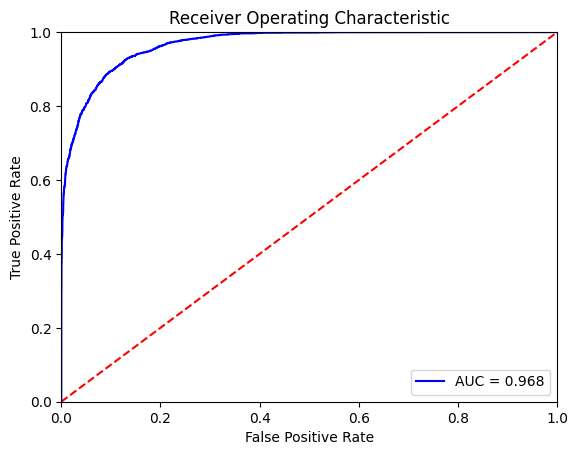

In [12]:
fpr, tpr, threshold = roc_curve(y_test_tensor, pred_win_rate_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f"AUC = {roc_auc_score(y_test_tensor, pred_win_rate_test):.3}")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()